Thông tin cơ bản về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object      

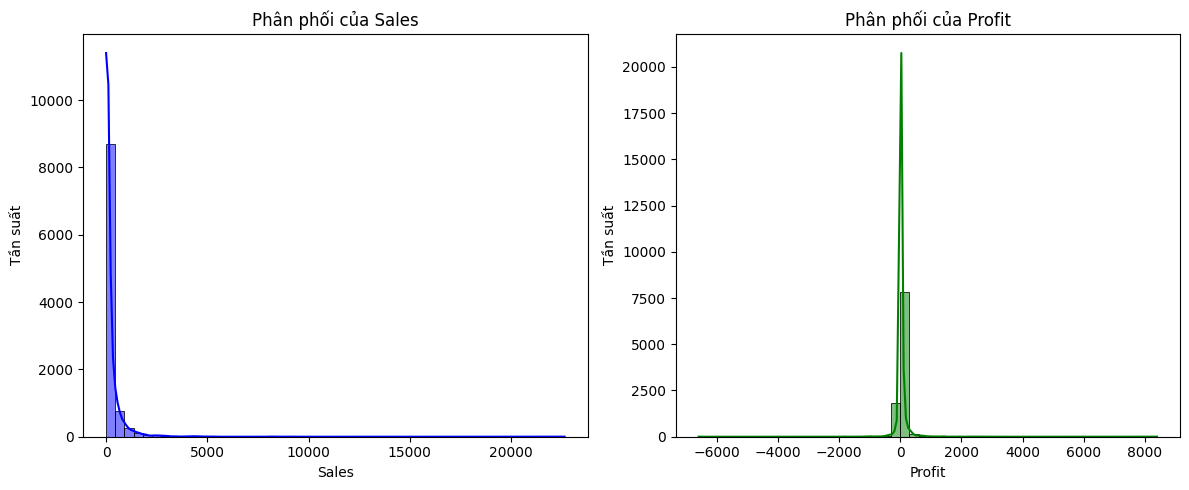

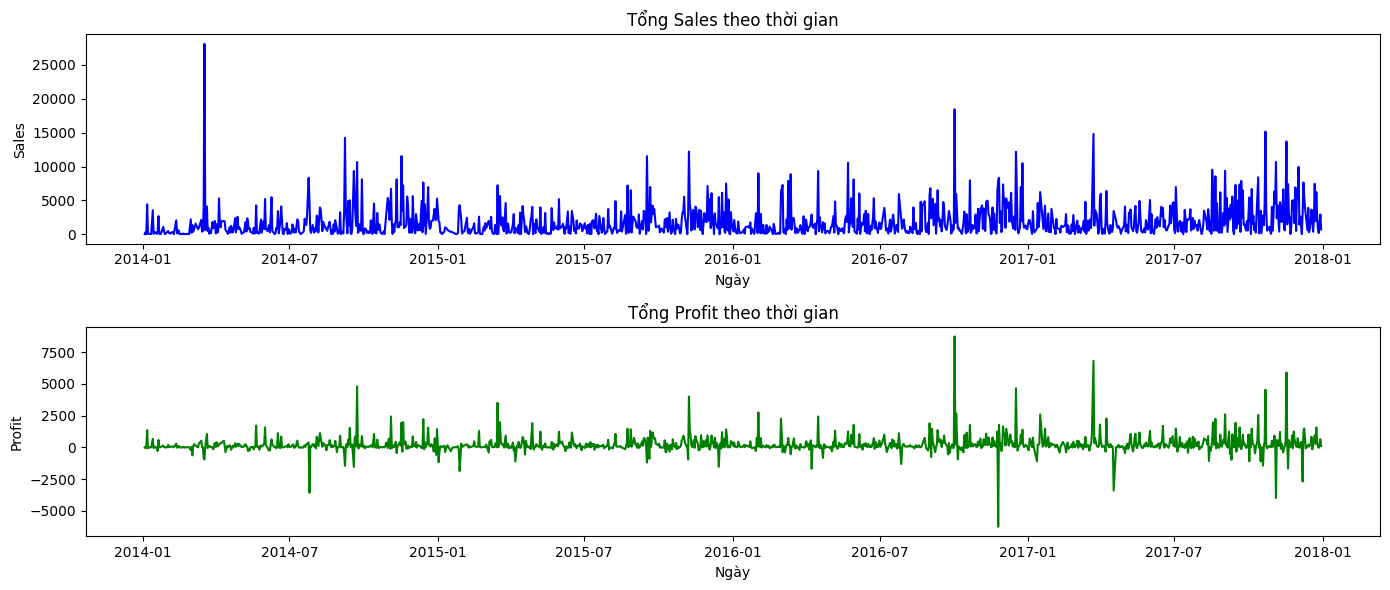

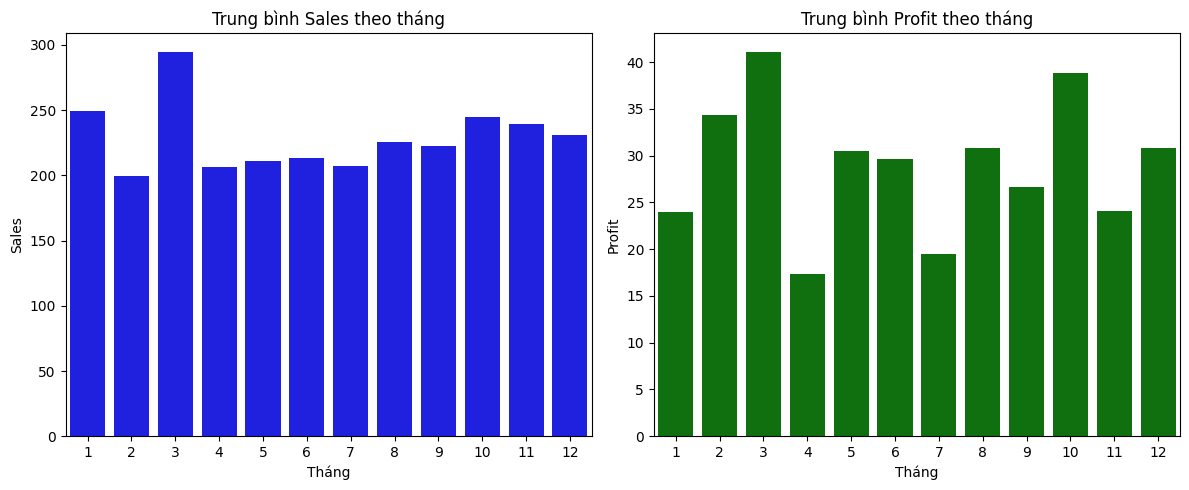

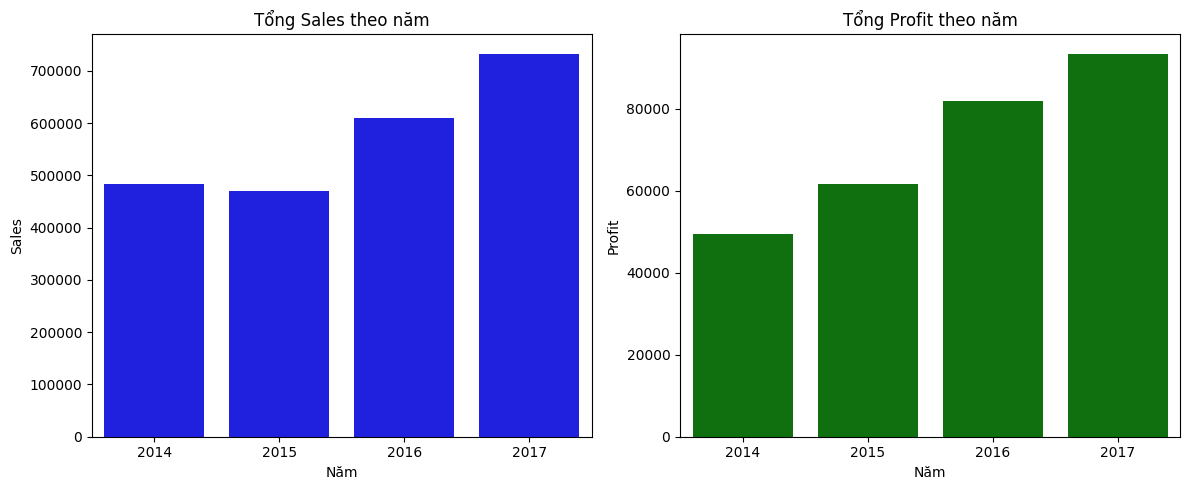

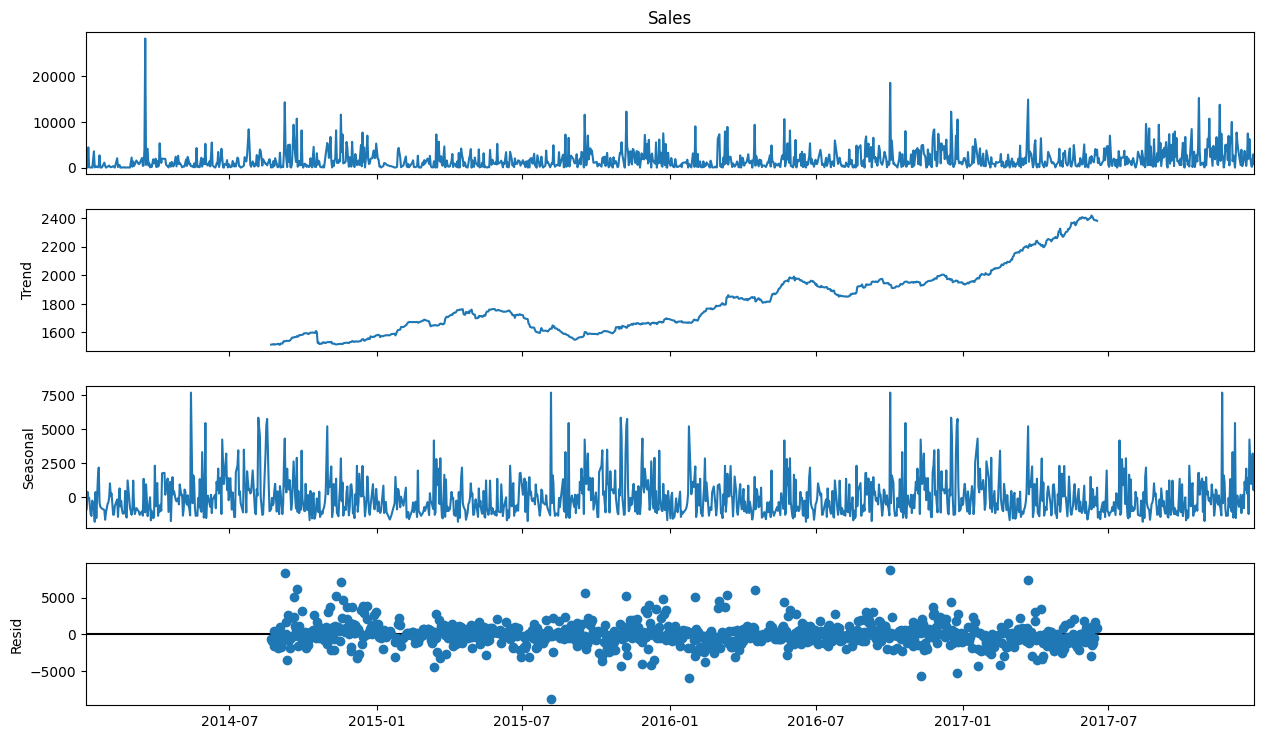

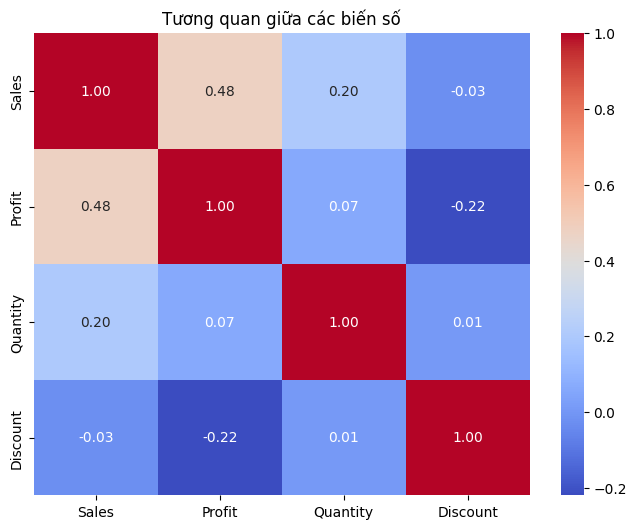


Đánh giá mô hình cho Sales:
Train set:
  MAE: 0.41797140690656037
  MSE: 0.7743923535108022
  R2 Score: 0.9999620009355229
Test set:
  MAE: 1.8066174054911257
  MSE: 44.99883117019676
  R2 Score: 0.998010431218389


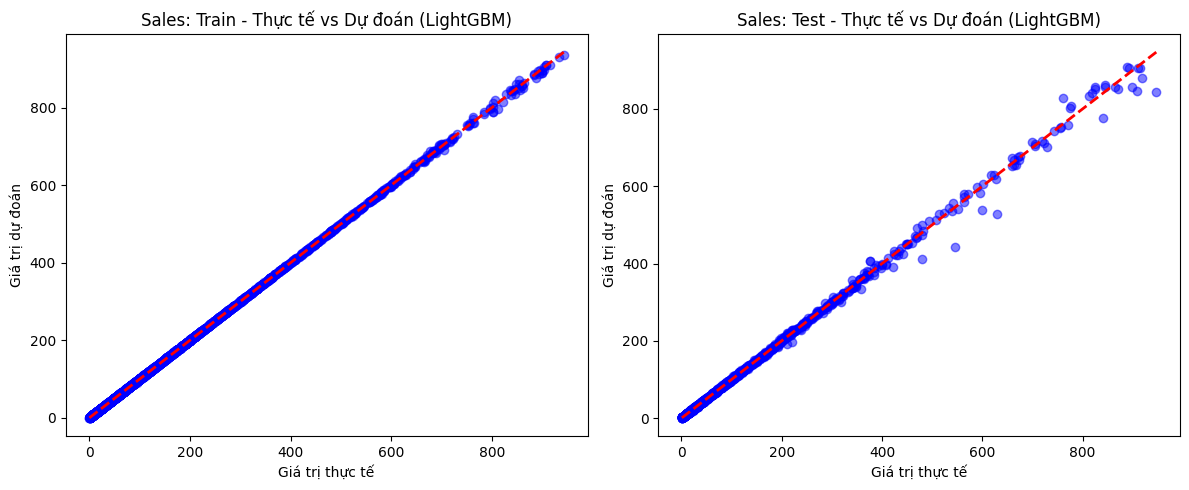


Đánh giá mô hình cho Profit:
Train set:
  MAE: 0.6155121763867413
  MSE: 1.123876606337036
  R2 Score: 0.9981722054147448
Test set:
  MAE: 2.61377490951133
  MSE: 39.06121906603132
  R2 Score: 0.9337021770877738


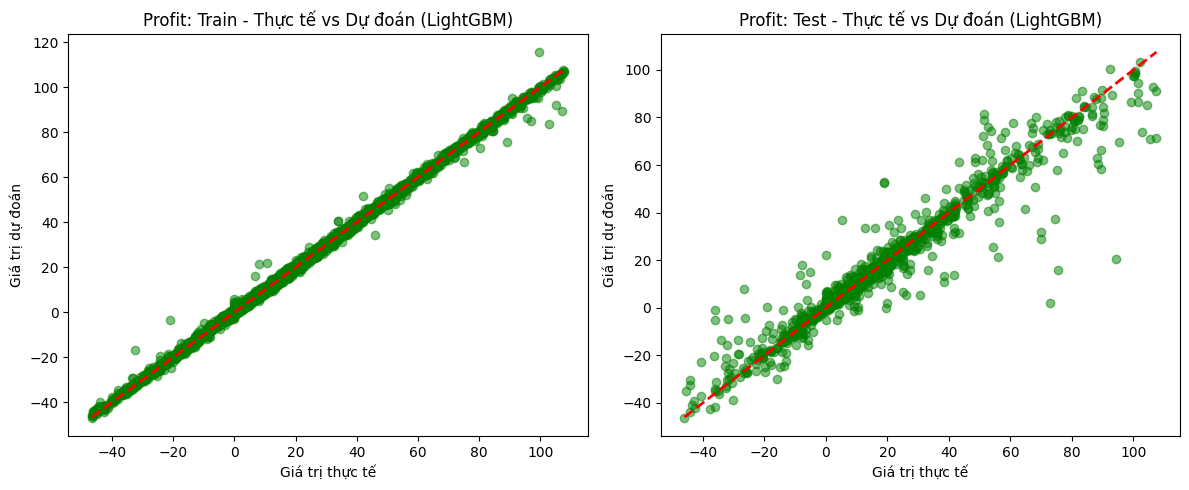

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# 1. Đọc dữ liệu
data = pd.read_csv('Sample - Superstore.csv', encoding='latin1')

# 2. Chuyển đổi cột thời gian
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

# 3. EDA: Phân tích dữ liệu
print("Thông tin cơ bản về dữ liệu:")
print(data.info())
print("\nThống kê mô tả:")
print(data.describe())

# 3.1. Kiểm tra giá trị thiếu
print("\nKiểm tra giá trị thiếu:")
print(data.isnull().sum())

# 3.2. Phân phối của Sales và Profit
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['Sales'], bins=50, kde=True, color='blue')
plt.title('Phân phối của Sales')
plt.xlabel('Sales')
plt.ylabel('Tần suất')

plt.subplot(1, 2, 2)
sns.histplot(data['Profit'], bins=50, kde=True, color='green')
plt.title('Phân phối của Profit')
plt.xlabel('Profit')
plt.ylabel('Tần suất')
plt.tight_layout()
plt.show()

# 3.3. Xu hướng Sales và Profit theo thời gian
# Tổng hợp Sales và Profit theo ngày
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()
daily_profit = data.groupby('Order Date')['Profit'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(daily_sales['Order Date'], daily_sales['Sales'], color='blue')
plt.title('Tổng Sales theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Sales')

plt.subplot(2, 1, 2)
plt.plot(daily_profit['Order Date'], daily_profit['Profit'], color='green')
plt.title('Tổng Profit theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()

# 3.4. Phân tích theo tháng
data['Order_Month'] = data['Order Date'].dt.month
monthly_sales = data.groupby('Order_Month')['Sales'].mean().reset_index()
monthly_profit = data.groupby('Order_Month')['Profit'].mean().reset_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Order_Month', y='Sales', data=monthly_sales, color='blue')
plt.title('Trung bình Sales theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Sales')

plt.subplot(1, 2, 2)
sns.barplot(x='Order_Month', y='Profit', data=monthly_profit, color='green')
plt.title('Trung bình Profit theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()

# 3.5. Phân tích theo năm
data['Order_Year'] = data['Order Date'].dt.year
yearly_sales = data.groupby('Order_Year')['Sales'].sum().reset_index()
yearly_profit = data.groupby('Order_Year')['Profit'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Order_Year', y='Sales', data=yearly_sales, color='blue')
plt.title('Tổng Sales theo năm')
plt.xlabel('Năm')
plt.ylabel('Sales')

plt.subplot(1, 2, 2)
sns.barplot(x='Order_Year', y='Profit', data=yearly_profit, color='green')
plt.title('Tổng Profit theo năm')
plt.xlabel('Năm')
plt.ylabel('Profit')
plt.tight_layout()
plt.show()

# 3.6. Phân tích mùa vụ (seasonality) với seasonal_decompose
daily_sales.set_index('Order Date', inplace=True)
decomposition = seasonal_decompose(daily_sales['Sales'], model='additive', period=365)  # Chu kỳ 1 năm
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

# 3.7. Tương quan giữa các biến số
numeric_cols = ['Sales', 'Profit', 'Quantity', 'Discount']
plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Tương quan giữa các biến số')
plt.show()

# 4. Tiền xử lý dữ liệu
# 4.1. Xử lý giá trị ngoại lai
sales_upper_limit = data['Sales'].quantile(0.95)
data = data[data['Sales'] <= sales_upper_limit]
profit_lower_limit = data['Profit'].quantile(0.05)
profit_upper_limit = data['Profit'].quantile(0.95)
data = data[(data['Profit'] >= profit_lower_limit) & (data['Profit'] <= profit_upper_limit)]

# 4.2. Tạo đặc trưng thời gian
data['Order_DayOfWeek'] = data['Order Date'].dt.dayofweek
data['Order_Quarter'] = data['Order Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
data['Season'] = data['Order_Month'].apply(get_season)
data['Shipping_Delay'] = (data['Ship Date'] - data['Order Date']).dt.days

# 4.3. Tạo các đặc trưng khác
data['Sales_per_Quantity'] = data['Sales'] / data['Quantity']
data['Discounted_Sales'] = data['Sales'] * (1 - data['Discount'])
data['Estimated_Cost'] = data['Sales'] - data['Profit']
data['Quantity_Discount'] = data['Quantity'] * data['Discount']

# 4.4. Loại bỏ cột không cần thiết
columns_to_drop = ['Order ID', 'Customer ID', 'Product ID', 'Customer Name', 'Product Name', 'City', 'Country', 'Order Date', 'Ship Date']
data = data.drop(columns=columns_to_drop)

# 4.5. Mã hóa biến phân loại (LightGBM có thể xử lý trực tiếp, nhưng cần Label Encoding trước)
le = LabelEncoder()
categorical_cols = ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Region', 'State', 'Season']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# 4.6. Chuẩn hóa dữ liệu số
numeric_cols = ['Quantity', 'Discount', 'Shipping_Delay', 'Sales_per_Quantity', 'Discounted_Sales', 'Estimated_Cost', 'Quantity_Discount', 'Order_Year', 'Order_Month', 'Order_DayOfWeek', 'Order_Quarter']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# 4.7. Xử lý NaN
data = data.dropna()

# 5. Tách biến đầu vào (X) và đầu ra (y)
X = data.drop(columns=['Sales', 'Profit'])
y_sales = data['Sales']
y_profit = data['Profit']

# 6. Chia dữ liệu
X_train, X_test, y_sales_train, y_sales_test = train_test_split(X, y_sales, test_size=0.2, random_state=42)
X_train, X_test, y_profit_train, y_profit_test = train_test_split(X, y_profit, test_size=0.2, random_state=42)

# 7. Chuyển dữ liệu thành định dạng LightGBM Dataset
train_data_sales = lgb.Dataset(X_train, label=y_sales_train, categorical_feature=categorical_cols)
test_data_sales = lgb.Dataset(X_test, label=y_sales_test, reference=train_data_sales)
train_data_profit = lgb.Dataset(X_train, label=y_profit_train, categorical_feature=categorical_cols)
test_data_profit = lgb.Dataset(X_test, label=y_profit_test, reference=train_data_profit)

# 8. Thiết lập tham số cho LightGBM
params = {
    'objective': 'regression',
    'metric': 'l2',  # MSE
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# 9. Huấn luyện mô hình LightGBM
# Mô hình cho Sales
model_sales = lgb.train(params, train_data_sales, num_boost_round=1000, valid_sets=[test_data_sales])
y_sales_pred_train = model_sales.predict(X_train)
y_sales_pred_test = model_sales.predict(X_test)

# Mô hình cho Profit
model_profit = lgb.train(params, train_data_profit, num_boost_round=1000, valid_sets=[test_data_profit])
y_profit_pred_train = model_profit.predict(X_train)
y_profit_pred_test = model_profit.predict(X_test)

# 10. Đánh giá mô hình
def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test, target_name):
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)

    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    r2_test = r2_score(y_true_test, y_pred_test)

    print(f"\nĐánh giá mô hình cho {target_name}:")
    print("Train set:")
    print("  MAE:", mae_train)
    print("  MSE:", mse_train)
    print("  R2 Score:", r2_train)
    print("Test set:")
    print("  MAE:", mae_test)
    print("  MSE:", mse_test)
    print("  R2 Score:", r2_test)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true_train, y_pred_train, color='blue' if target_name == 'Sales' else 'green', alpha=0.5)
    plt.plot([y_true_train.min(), y_true_train.max()], [y_true_train.min(), y_true_train.max()], 'r--', lw=2)
    plt.title(f'{target_name}: Train - Thực tế vs Dự đoán (LightGBM)')
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_test, y_pred_test, color='blue' if target_name == 'Sales' else 'green', alpha=0.5)
    plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2)
    plt.title(f'{target_name}: Test - Thực tế vs Dự đoán (LightGBM)')
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')

    plt.tight_layout()
    plt.show()

# Đánh giá
evaluate_model(y_sales_train, y_sales_pred_train, y_sales_test, y_sales_pred_test, "Sales")
evaluate_model(y_profit_train, y_profit_pred_train, y_profit_test, y_profit_pred_test, "Profit")